# **Document Preprocessing**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ingest_data.py (The CORRECTED version)

import os
from dotenv import load_dotenv

from langchain_community.document_loaders import TextLoader # <-- The new, correct loader!
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore

# --- 1. Setup Environment ---
load_dotenv()


# The path to your final, clean text file
CLEAN_TEXT_FILE_PATH = "Bangla-Book/book-data.txt" # <-- IMPORTANT

# --- 2. Load the CLEAN Document ---
loader = TextLoader(CLEAN_TEXT_FILE_PATH, encoding='utf-8')
documents = loader.load()

print(f"Successfully loaded the clean document.")
# The 'documents' object will be a list with a single, large Document in it.




Successfully loaded the clean document.


## **Chunking the Documents**

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100
)

In [4]:
all_chunks = splitter.split_documents(documents=documents)
len(all_chunks)

118

In [5]:
all_chunks[50].page_content

"**গ. অনুপম ও পারভেজের চারিত্রিক বৈশিষ্ট্যের বৈপরীত্য ব্যাখ্যা কর।**\n**সমাধান:** অপরিচিতা' গল্পের অনুপম ও উদ্দীপকের পারভেজের চারিত্রিক বৈশিষ্ট্যে বৈপরীত্য দেখা যায়।\nঅনেক যুবক আছে যারা উচ্চশিক্ষিত হলেও তাদের মানস সুগঠিত নয়। তারা নিজেদের সিদ্ধান্ত নিজেরা নিতে পারে না। পরিবারতন্ত্রের চাপে সিদ্ধান্তের জন্য পরিবারের কর্তাব্যক্তিদের ওপর নির্ভর করতে হয়। তাই বিয়ের মতো গুরুত্বপূর্ণ সিদ্ধান্তের ক্ষেত্রেও তারা পরিবারের পছন্দ-অপছন্দের ওপর নির্ভর করে।"

## **Embedding Model From HF**

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [7]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [8]:
# from langchain_huggingface import HuggingFaceEmbeddings

# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [9]:
len(embeddings.embed_query("সময়"))

768

## **Pinecone Vector DB**

In [10]:
from pinecone import Pinecone
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [11]:
pc = Pinecone(api_key=pinecone_api_key)

In [12]:
from pinecone import ServerlessSpec ## you are not going to mange the server. and its managed by the cloud provider.
## create index
index_name = "10ms-db-hsc-updated"

if not pc.has_index(index_name):
    pc.create_index(
    name=index_name,
    dimension=768,
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

# **Load the db**

In [13]:
index = pc.Index(index_name)
index

In [14]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [15]:
vector_store.add_documents(documents=all_chunks)

['2404d67b-30b4-4273-b859-9c2d72f6db1e',
 'b80275d0-0a47-4bc5-9a36-8b3922ccf5a5',
 '66870bfe-ecd1-4f7c-96e3-deaaf366bfab',
 'f620bb76-9c4c-4140-83d6-36566fc4646c',
 '0e0b3adc-e1cd-45ab-a6ae-17a3defd330e',
 '548eccf5-3fe6-4c29-ba97-8fd24412fe82',
 'bcb84248-5db3-4ebe-bb96-ee555cd8d528',
 '555e43cf-cb53-4d51-8a5b-df600b03d678',
 '948af0f4-1485-44e9-9c44-b4f4a1e468a7',
 '262970b0-b96f-4ab6-92ad-d7b418bdd185',
 'cf4ab67c-1aa8-486a-8439-3705dba284b4',
 '604ee7b4-8542-4168-a3cb-88b604276806',
 '534673c6-7125-4279-832a-021aca7f49c5',
 '8bdd4de5-1482-44a5-a5c9-ae87a3bb9560',
 'a08db54b-c25d-4bfc-9820-dba8998a0a5c',
 '305ba2ec-9034-462c-85c9-9d2e5a66c6be',
 '5821dd51-fcc4-4f85-a378-c7c2eb6f9abd',
 '2d19fac4-7077-45d5-ab7c-e63b340ccb58',
 '1e12d238-14b8-42b2-8f9a-24d0708b783f',
 'dc758ab4-2539-4ba4-911b-134ffe418d0e',
 '9af1fc9c-e132-4962-842c-e92badeb4f27',
 'de40dc95-284f-4e78-9610-f6c7081d5bb8',
 'cd03bb8e-e4fa-4b55-913c-7d60a446b561',
 '217e6589-2e0c-4245-aabc-a9ecc946aefe',
 'ea7a65dd-3ea3-

In [16]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [49]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 5
    }
)

In [50]:
response = retriever.invoke("বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?")
response

[Document(id='d0aed599-a477-414e-847f-4468e6ee6348', metadata={'source': 'Bangla-Book/book-data.txt'}, page_content="**গ. উদ্দীপকের পরেশ 'অপরিচিতা' গল্পের কোন চরিত্রের বিপরীত? ব্যাখ্যা কর।**"),
 Document(id='a068a77a-595b-421d-a004-35bd420072b3', metadata={'source': 'Bangla-Book/book-data.txt'}, page_content="**ঘ. 'অপরিচিতা' গল্পের উদ্দিষ্ট চরিত্র যদি উদ্দীপকের পরেশের মতো হতো, তাহলে গল্পের পরিণতি কেমন হতো? বিশ্লেষণ কর।**"),
 Document(id='b566dade-ac10-4018-93bc-aed6a39373ff', metadata={'source': 'Bangla-Book/book-data.txt'}, page_content="**গ. উদ্দীপকের বরের বাপের সাথে 'অপরিচিতা' গল্পের অনুপমের মামার সাদৃশ্য ও বৈসাদৃশ্য নিরূপণ করো।**"),
 Document(id='57fe2c41-108b-42f1-8a80-a01f1d501734', metadata={'source': 'Bangla-Book/book-data.txt'}, page_content='মেয়েটি এবং কল্যাণী উভয়ই উভয়ের নির্ধারিত পাত্রের হৃদয়ে স্থান করে নিয়েছিল। তাই এ বিষয়টির মিল লক্ষ করা যায়।'),
 Document(id='d9ddfcc8-5503-47fe-be02-92c7fdc8a274', metadata={'source': 'Bangla-Book/book-data.txt'}, page_content='**গ. অ

## **Importing The LLMs**

In [51]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

## **Rag Prompt**

In [52]:
from langchain.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template=(
        "তুমি একজন সহায়ক বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দিতে হবে শুধুমাত্র প্রদত্ত প্রাসঙ্গিক তথ্য ব্যবহার করে। "
        "যদি প্রশ্নের উত্তর নিচের প্রসঙ্গে না থাকে, তাহলে বিনয়ের সাথে বলবে যে উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই। "
        "অতিরিক্ত কিছু কল্পনা বা অনুমান করো না।\n\n"

        "প্রাসঙ্গিক প্রসঙ্গ:\n{context}\n\n"
        "প্রশ্ন:\n{question}\n\n"
        "উত্তর (বাংলায় সংক্ষিপ্ত এবং স্পষ্টভাবে দিন):"
    ),
    input_variables=["question", "context"],
)


## **Formatted the Context data**

In [53]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

## **Define the `RAG` Chain**

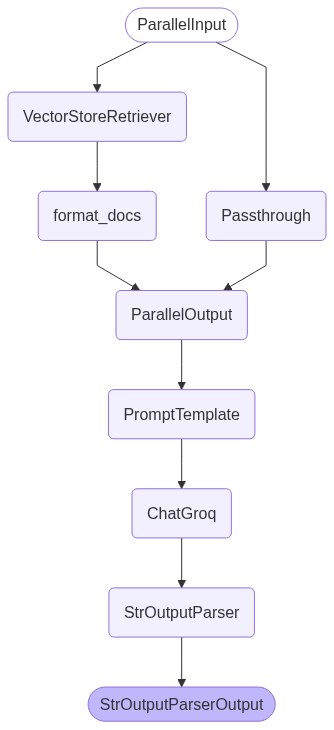

In [54]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [55]:
response = rag_chain.invoke("অপরিচিতা” প্রথম প্রকাশিত হয় প্রমথ চৌধুরী সম্পাদিত মাসিক 'সবুজপত্র' পত্রিকার ১৩২১ বঙ্গাব্দের (১৯১৪) কার্তিক সংখ্যায়।")
print(response)

উদ্দীপকের নায়কের মতো অনুপমের বিরহের জন্য নিজের অক্ষমতাই দায়ী।

পিতৃবিয়োগের পর থেকেই অনুপম বাইরে কাজ করে খায়। আর এজন্যই বয়স বাড়ার সাথে সাথে লোকের মুখে মুখে তার সম্বন্ধে নানা কথা শুনতে হয়। একসময় তার বয়সী ছেলের বিয়ে হয়ে যায়। এসব কারণে অনুপমের মনে বিয়ে নিয়ে ভীষণ উৎকণ্ঠার সৃষ্টি হয়। সে ভাবত, বিয়ে করলে নিশ্চয়ই কেউ না কেউ একটু খবর নিয়ে আসবে। খবর এনে শুনে নেবে। বিয়ের লগ্ন পাকাপাকি হলে হয়তো বা বাপের বাড়ির কেউ একজন লোক পাঠিয়ে দেবে। এভাবে সে লগ্নে এসেছে পালিয়ে।

উদ্দীপকের নায়ক পরেশ বিয়ের লগ্নে গিয়ে পৌঁছলেও বিয়ে করতে পারেনি। কারণ তার মা বরপক্ষের চাহিদা পূরণ করতে না পারায় সে লজ্জায় ও ক্ষোভে পালিয়ে আসে। যেমন পরেশ ভাবছিল, 'আমি লগ্নে এসেছি পালিয়ে।' এখানে পরেশের অবস্থা অনুপমের মতোই। অনুপমের বিয়ে হয়নি বলে সে লগ্নে পালিয়ে এসেছে। পরেশের বিয়ে হয়নি বলে সে লগ্নে এসে পালিয়ে যাচ্ছে। এক্ষেত্রে দুজনের অবস্থান একই রকম।

পরেশের মা-ই কন্যাপক্ষকে গহনার তালিকা দিয়েছিল। আর পরেশের বাবা গহনা কিনতে অসমর্থ হওয়ায় মায়ের অক্ষমতার জন্য সে লজ্জা ও ক্ষোভে পালিয়ে আসে। অন্যদিকে অনুপমের বি